In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `keras` framework.


In [5]:
TRAIN_PATH = "dataset/2d_slices/data_for_model/train/pre_processed_images"
TRAIN_MASK_PATH = "dataset/2d_slices/data_for_model/train/masks"

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[2]
mask_train_ids = next(os.walk(TRAIN_MASK_PATH))[2]

In [7]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [8]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float16)
Y_train = np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype = np.float16)

In [9]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+"/"+id_
    img = np.load(path)
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n]=np.expand_dims(img, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [01:56<00:00, 12.85it/s]


In [10]:
for n,id_ in tqdm(enumerate(mask_train_ids),total=len(mask_train_ids)):
    path=TRAIN_MASK_PATH+"/"+id_
    mask = np.load(path)
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    Y_train[n]=np.expand_dims(mask, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [02:23<00:00, 10.41it/s]


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Smallest pixel in image is [24.94]
Largest pixel in image is [255.]
Smallest pixel in mask is [0.]
Largest pixel in mask is [1.]


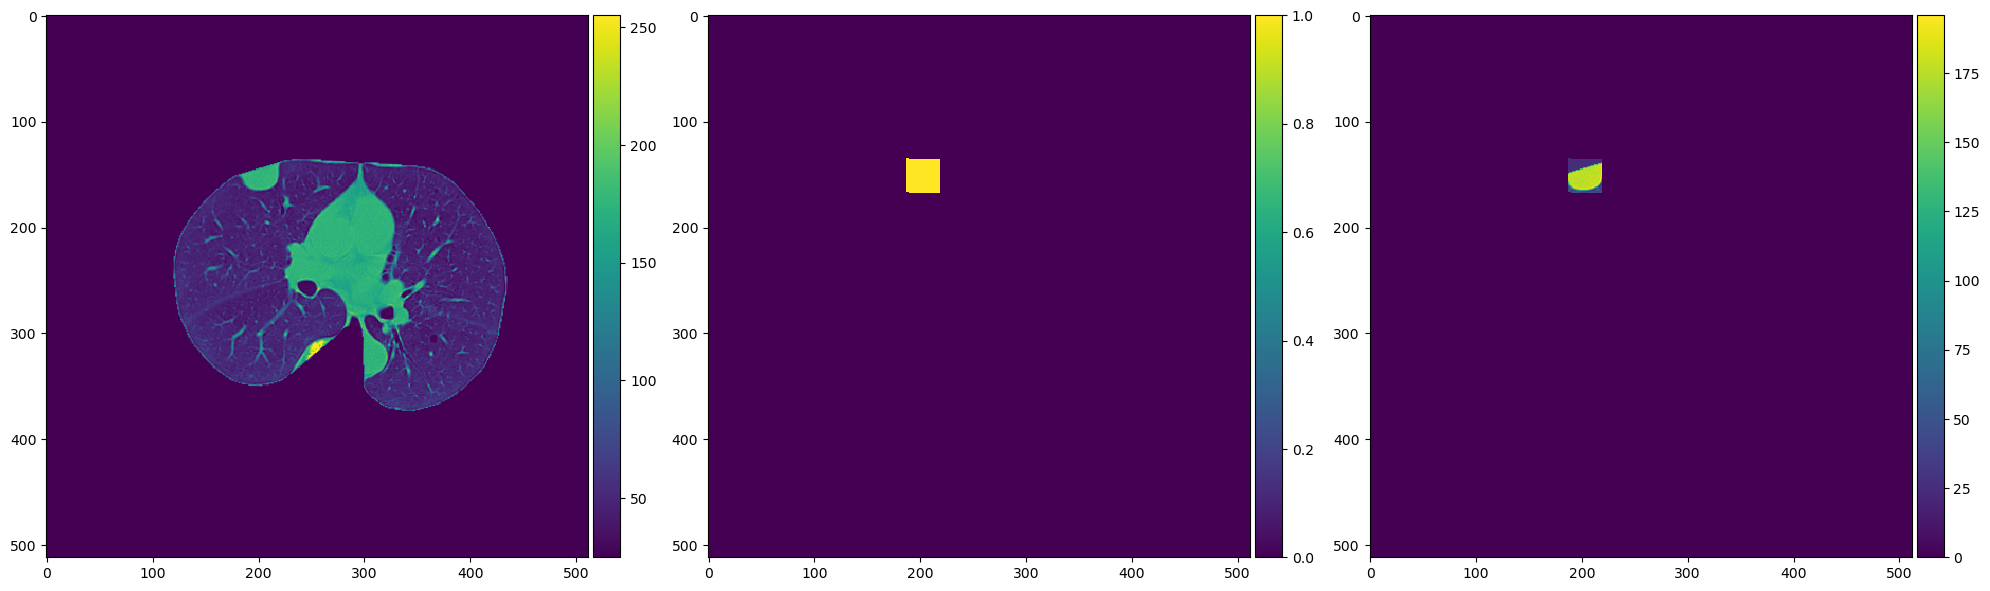

In [11]:
#Checking the training data
ix=random.randint(0,len(train_ids))
plt.figure(figsize=[20,10])
plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(Y_train[ix])
plt.subplot(133)
imshow((X_train[ix])*Y_train[ix])
smallest = X_train[ix].min(axis=(0, 1))
largest = X_train[ix].max(axis=(0, 1))
print("Smallest pixel in image is",smallest)
print("Largest pixel in image is", largest)
smallest = Y_train[ix].min(axis=(0, 1))
largest = Y_train[ix].max(axis=(0, 1))
print("Smallest pixel in mask is",smallest)
print("Largest pixel in mask is", largest)


In [12]:
X_train = np.array(X_train) / 255.

In [13]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# def dice_coef(y_true, y_pred, smooth = 100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice
def dice_coef(y_true, y_pred, smooth = 1e-5):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_scores_tensor = (2. * intersection + smooth) / (union + smooth)
    mean_dice_score = tf.reduce_mean(dice_scores_tensor)
    return mean_dice_score

In [14]:
def dice_coef_loss_and_bce(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#     term_1 = y_true * K.log(y_pred + K.epsilon())
#     bce_loss = -K.mean(term_0 + term_1)
#     mean = 0.8*(dice_loss) + 0.2*(bce_loss)
    return dice_loss

In [15]:
SM_FRAMEWORK=tf.keras
sm.set_framework('tf.keras')

In [16]:
from keras.layers import Input, Conv2D
from keras.models import Model

In [17]:
BACKBONE = "vgg16"

In [18]:
base_model = sm.Unet(BACKBONE,encoder_weights="imagenet",encoder_freeze=False)

In [19]:
inp = Input(shape=(None, None, 1))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

In [20]:
model = Model(inp,out,name=base_model.name)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00003),loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     6         
                                                                 
 model (Functional)          (None, None, None, 1)     23752273  
                                                                 
Total params: 23,752,279
Trainable params: 23,748,247
Non-trainable params: 4,032
_________________________________________________________________


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./lungnodule_transfer_learning.h5",verbose=1,save_best_only=True)
callbacks=[
    #tf.keras.callbacks.EarlyStopping(patience=20,monitor="dice_coef"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [ ]:
 results = model.fit(X_train,Y_train,validation_split=0.2,batch_size=8,epochs=60,callbacks=callbacks )

Epoch 1/60
 54/150 [=========>....................] - ETA: 59:43 - loss: 0.9976 - dice_coef: 0.0024  

In [ ]:
# model = sm.Unet(BACKBONE, classes=1,activation="sigmoid",encoder_weights="imagenet",encoder_freeze=False)

In [ ]:
# model.compile(
#     'Adam',
#     loss=sm.losses.bce_jaccard_loss,
#     metrics=[sm.metrics.iou_score],
# )

In [ ]:
# model.fit(
#    x=x_train,
#    y=Y_train,
#    batch_size=2,
#    validation_split=0.2,
#    epochs=130,
# )

In [ ]:
dice_coef = results.history['dice_coef']
val_dice_coef = results.history['val_dice_coef']
loss = results.history['loss']
val_loss = results.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(dice_coef) + 1)

plt.plot(epochs, dice_coef, 'b', label='Training dice coefficent',color="green")
plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coefficient',color="blue")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.savefig('vanilla_train_diceloss_bs32.png')
plt.plot(epochs, loss, 'b', label='Training loss',color="green")
plt.plot(epochs, val_loss, 'b', label='Validation loss',color="blue")
plt.title('Training and validation loss')
plt.legend()
plt.savefig('vanilla_loss_diceloss_bs32.png')

plt.show()

### Checking Prediction on Test Data set

In [ ]:
model_unet=tf.keras.models.load_model("lungnodule_vanilla_higher_epoch.h5",compile=False)

In [ ]:
y_pred=model_unet.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [ ]:
intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
dice_score = (2*np.sum(intersection)) / np.sum(union)
print("Dice score on test dataset is: ", dice_score)

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model_unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()